# RNN 이해 및 실습 1

## 1. 시계열 데이터

- 예제 시계열 만들기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

xarr = np.array([100,200,300,400])
yarr = np.array([1,2,3,4])
cond = ([True,False,True,False])
np.where(cond,xarr,yarr) #cond True->xarr, False ->yarr

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


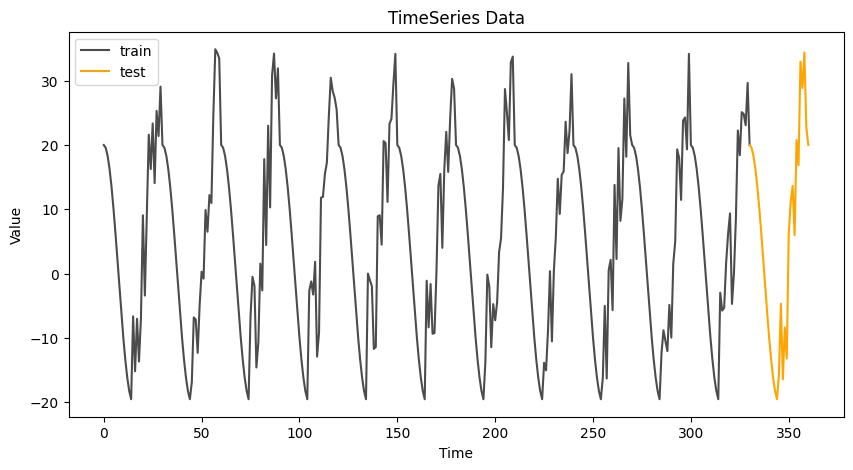

In [2]:
plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

In [ ]:
time_series[0:10]

array([20.        , 19.56295201, 18.27090915, 16.18033989, 13.38261213,
       10.        ,  6.18033989,  2.09056927, -2.09056927, -6.18033989])

## 2. 시계열 데이터 전처리 : Sequence를 만들기

In [3]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩
    x_train, y_train = list(), list()

    for i in range(len(time_series)):  #0
        x = time_series[i:(i + n)]      #0:0+n
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)

In [4]:
n = 15
x_train, y_train = make_sequence(time_series, n)
x_train.shape


(346, 15)

In [5]:
x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

In [6]:
print(x_train.shape)
print(y_train.shape)

(346, 15, 1)
(346, 1)


In [7]:
partial_x_train = x_train[:30 * 11]
partial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', partial_x_train.shape, partial_y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (330, 15, 1) (330, 1)
test: (16, 15, 1) (16, 1)


## 3. sequence 함수 확인하기

In [ ]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 15)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] | 16
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] | 17
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] | 18


## 4. SimpleRNN 구축

- tanh: Hyperbolic tangent 함수
- -1~1사이의 값, 출력범위가 sigmoid보다 크고, 경사가 큰 구간이 많아 sigmoid보다 빠르게 수렴하여 학습하는 특성
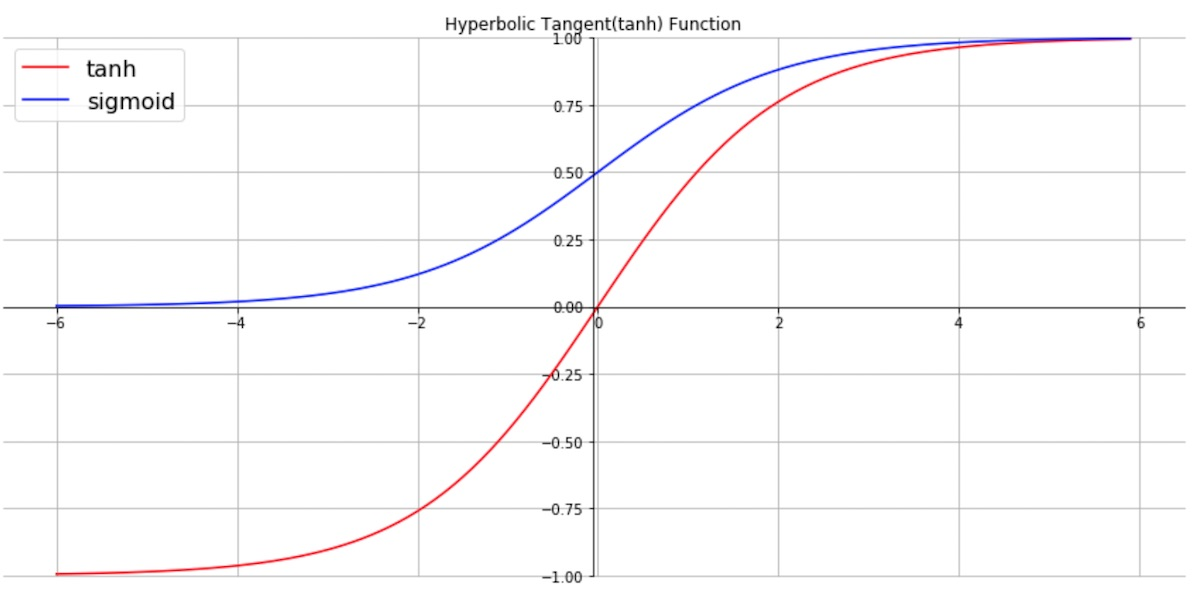

In [8]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
#model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train, y_train, epochs = 30, batch_size = 1)

## 5. 예측 VS Actual


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


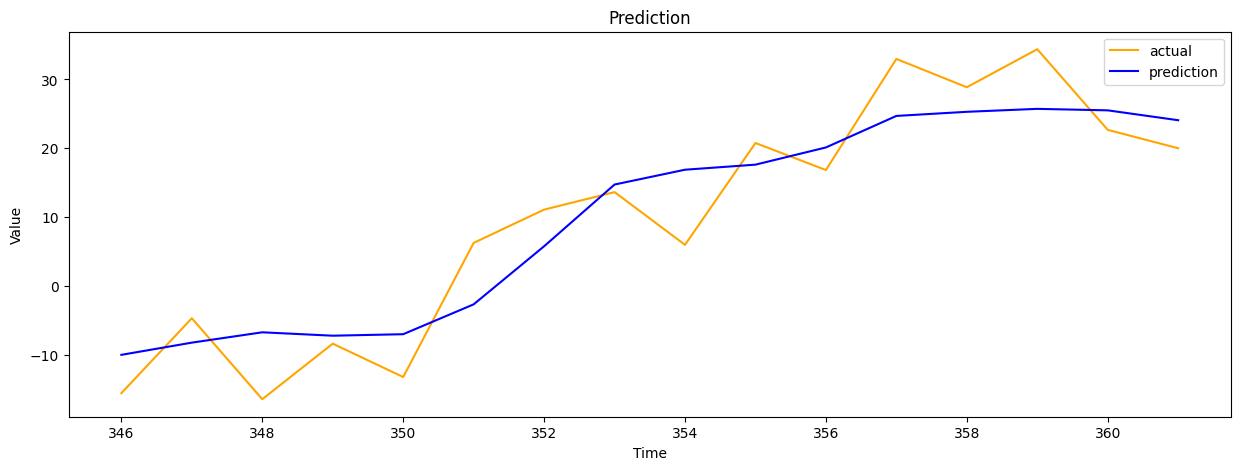

In [ ]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

In [11]:
#daily-min-temperature.csv
#n=10
#1~3600행은 train, 나머지 test
#RNN, ML 비교 (MSE로 비교)
#SimpleRNN, Dense, Dense......
import pandas as pd
data = pd.read_csv('daily-min-temperatures.csv', index_col=0)
data = data.values

n = 10
x, y = make_sequence(data, n)

X_train = x[0:3600, :]
X_test = x[3600:, :]

y_train = y[0:3600]
y_test = y[3600:]

X_train = X_train.reshape(-1, n, 1)
X_test = X_test.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.fit(X_train, y_train, epochs=30)
pred_rnn = model.predict(X_test)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor()
model2.fit(X_train.reshape(-1, n), y_train)
pred_gb = model2.predict(X_test.reshape(-1, n))

In [21]:
from sklearn.metrics import mean_squared_error
y_test = y[3600:]
print(mean_squared_error( y_test, pred_rnn))
print(mean_squared_error( y_test, pred_gb))

4.309279935300763
4.27659808431441


# RNN 이해 및 실습 2
## 1. 시계열 데이터




- 기간을 2024.11.30까지.
- 다른 회사...
- train: 1000개, 나머지 가 테스트
- RNN-> LSTM
- Dense 추가
- MSE

In [27]:
import numpy as np
import pandas as pd
import yfinance as yf

AMZN = yf.download('GOOG', start="2020-01-01", end="2024-11-30")

AMZN = AMZN.round(2)
AMZN.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2020-01-02 00:00:00+00:00,68.20,68.37,68.41,67.08,67.08,28132000
2020-01-03 00:00:00+00:00,67.87,68.03,68.62,67.28,67.39,23728000
2020-01-06 00:00:00+00:00,69.54,69.71,69.82,67.50,67.50,34646000
2020-01-07 00:00:00+00:00,69.50,69.67,70.15,69.52,69.90,30054000
2020-01-08 00:00:00+00:00,70.04,70.22,70.58,69.54,69.60,30560000


In [28]:
AMZN['Adj Close'].values

array([[ 68.2 ],
       [ 67.87],
       [ 69.54],
       ...,
       [170.62],
       [170.82],
       [170.49]])

In [29]:
n = 5
x, y = make_sequence(AMZN["Adj Close"].values, n)
x = x.reshape(-1, n, 1)
y = y.reshape(-1, 1)

In [30]:
print(x.shape)
print(y.shape)

(1232, 5, 1)
(1232, 1)


In [31]:
test_len = 1000
x_train = x[:test_len]
y_train = y[:test_len]
x_test = x[test_len:]
y_test = y[test_len:]

print('train:', x_train.shape, y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (1000, 5, 1) (1000, 1)
test: (232, 5, 1) (232, 1)


## 2. SimpleRNN 구축

In [40]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
#model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(16, activation = 'relu'))
#rnn은 이전 단계의 가중치를 사용하며, relu 를 사용하면, 역전파 시 이전 단계의 그라디언트와 같이 사용되면 출력이 발산
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(x_train, y_train, epochs = 30, batch_size = 1)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7300.0552
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 40.6240
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 11.1086
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.4944
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.7465
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.1088
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.5483
Epoch 8/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.6081
Epoch 9/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1691
Epoch 10/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 11.4839
Epoch 11/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.3857
Epoch 12/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.1381
Epoch 13/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.3759
Epoch 14/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.6554
Epoch 15/30
1000/1000 

## 3. SimpleRNN 예측 VS Actual


In [ ]:
pred = model.predict(x_test)
pred

In [43]:
mean_squared_error(y_test[0:50], pred[0:50])

17.585787271402836

In [44]:
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

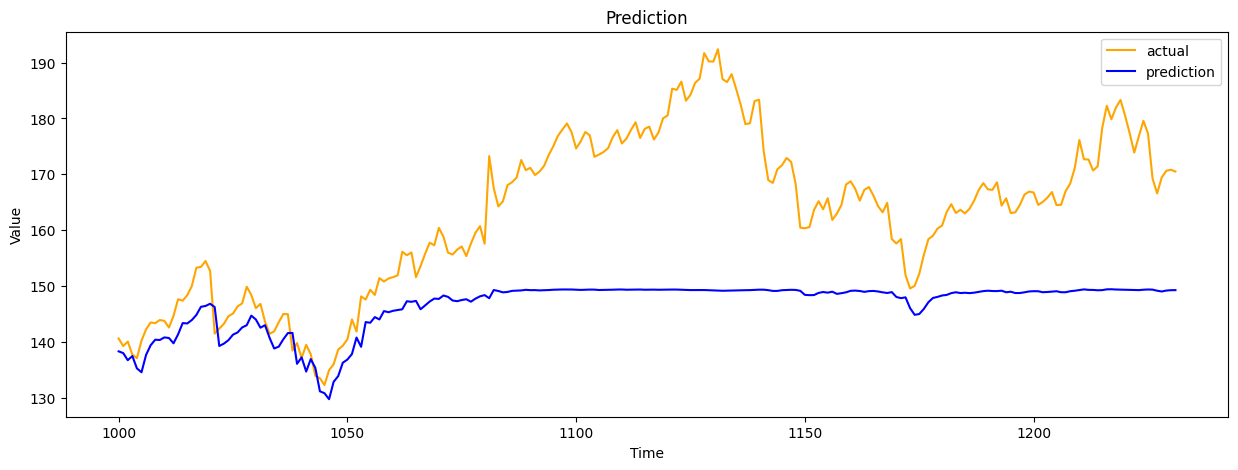

In [45]:
plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 4. LSTM 사용 및 예측 결과

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

LSTM_model = Sequential()
LSTM_model.add(LSTM(units = 50, activation = 'tanh', input_shape = (n, 1), return_sequences=True))
LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
LSTM_model.add(Dense(1, activation = 'linear'))

LSTM_model.compile(optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss = 'mse')  #mean squared error
LSTM_model.fit(x_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 15695.3828
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6287.3931
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2305.7544
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1772.3322
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1492.0275
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 973.2356
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 838.7286
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 801.1042
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 777.4287
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 799.4557
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 727.5522
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 753.1505
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 770.9110
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 734.8651
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 777.406

In [ ]:
pred = model.predict(x_test)
pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[ 89.91902 ],
       [ 89.95505 ],
       [ 90.976746],
       [ 90.68581 ],
       [ 89.47777 ],
       [ 91.07798 ],
       [ 92.21237 ],
       [ 94.18349 ],
       [ 99.15198 ],
       [ 99.983246],
       [102.12759 ],
       [100.518936],
       [ 99.31097 ],
       [ 97.73714 ],
       [100.999916],
       [101.95915 ],
       [100.43982 ],
       [101.00008 ],
       [103.1888  ],
       [106.22453 ],
       [104.746376],
       [106.51994 ],
       [108.62181 ],
       [115.6785  ],
       [108.092094],
       [104.937836],
       [105.1474  ],
       [103.72154 ],
       [101.850266],
       [101.247696],
       [103.26256 ],
       [103.76567 ],
       [104.934685],
       [102.24869 ],
       [100.81537 ],
       [ 98.49567 ],
       [ 99.487305],
       [ 99.961586],
       [ 97.720634],
       [ 97.62402 ],
       [ 98.3123  ],
       [ 96.512   ],
       [ 96.14808 ],
       [ 98.86615 ],
       [ 98.248405],
       [ 97.587814],
       [ 97.98294 ],
       [ 96.5

In [ ]:
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

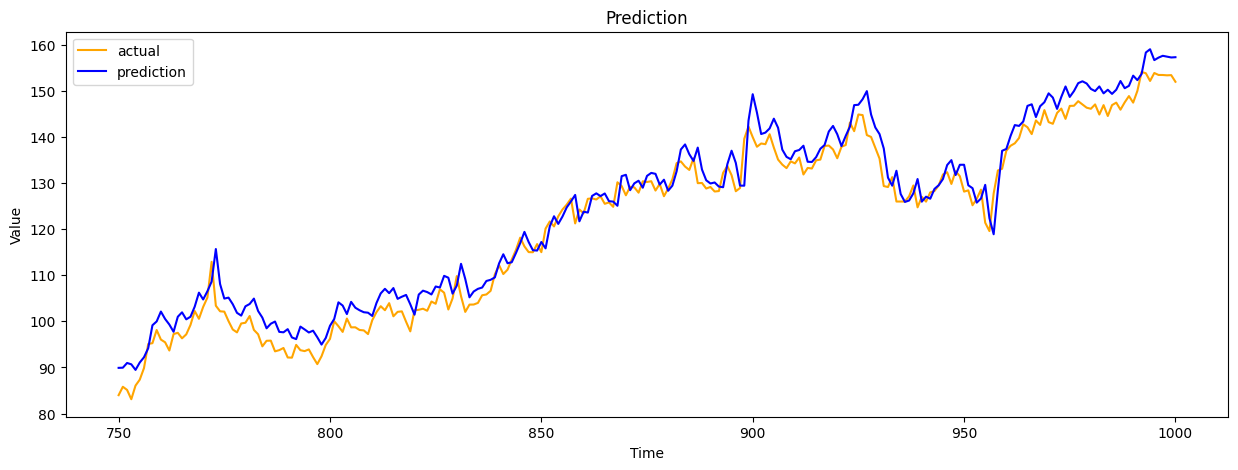

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

In [51]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00


In [ ]:
# shampoo.txt 읽으셔서 판매량을 시계열 모델링
# 끝에 10개 행을 test, 나머지 train
# min_max scaling
data = pd.read_csv("shampoo.txt", sep=",")
series = data.Sales.values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))

from pmdarima import auto_arima
model = auto_arima(series, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(series)

In [59]:
# arima
model.predict()
scaler.inverse_transform(model.predict().reshape(-1,1))
data.Sales[27:36].values

# n=3
# ml
# rnn
#mse


array([439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [ ]:
#pykrx 설치하셔서 국내주가에 대해서 모델링
!pip install pykrx

In [61]:
from pykrx import stock
df = stock.get_market_ohlcv_by_date("20221201", "20241130", "005930")

In [ ]:
#df에 대해서 ml, rnn계열로 분석, dnn
#train, test 2024 09~11
#mse

In [66]:
sereis = df.종가.values
#scaling

X, y = make_sequence( sereis, 5)
X_train = X[0:420, :]
X_test = X[420:, :]
y_train  = y[0:420]
y_test = y[420:]

from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, pred1))

3245104.107692308


In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model2 = Sequential()
model2.add( Dense( 10, activation='relu', input_shape=(5,) ))
model2.add( Dense( 5, activation='relu' ))
model2.add( Dense( 1, activation="linear"))
model2.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model2.fit(X_train, y_train, epochs=30)
pred2 = model2.predict(X_test)
print(mean_squared_error(y_test, pred2))

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model3 = Sequential()
model3.add( LSTM( 10, activation='relu', input_shape=(5,1) ))
model3.add( Dense( 5, activation='relu' ))
model3.add( Dense( 1, activation="linear"))
model3.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model3.fit(X_train.reshape(-1,n,1), y_train.reshape(-1, 1), epochs=30)
pred3 = model3.predict(X_test.reshape(-1, n,1))
print(mean_squared_error(y_test, pred3))